## Final testing for all candidate models (One Week Testing)

#### Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import torch
from statsmodels.graphics.tsaplots import plot_acf
import statistics
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True)
plt.rcParams["font.family"] = "serif"

### Dataset Creation

Dataset is generated from gross resturaunt sales over a period of three years. <br><br>
The dataset is not perfectly continuous. There are some days that are missing from the record. 
Also, the data is highly noisy. Part of this is due to holidays such as Christmas causing no sales in a day.
Partly, the noise is generated by features not easily captured in future forecasting such as the weather. <br>
Our data is from 9/11/2016 to 12/5/2019 - about three years of data. <br><br>
In total, we are missing 70 full days of sales data. One big continuous chunk of 63 days from 12/31/2017-3/4/2018. Also, 7 additional days from 5/31/19 to 6/8/19. Originally only 58 and 5 days were missing respectively, but we ensure that the gaps do not harm the weekly structure of our time series by increasing the missing window to encapsulate full weeks. This means each day in our series is preceeded and superceeded by the proper weekday. <br><br>
Some small adjustments must be made to a dataset to be within the specifics of certain models. As such, we define a few datasets below.<br><br>
In total, we have <b>1104</b> days of sales to create a dataset with since we need to throw out 7 days of sales.  

#### Actual Dataset

We use 80% of the data for training and 20% for testing metrics. 
Specifically, 883 days for training and 221 for testing.

In [2]:
train_time=883
time = np.arange(1104, dtype="float32")

In [4]:
data = pd.read_csv('RestaurantDataVets_All_2to5.csv')
data=data.drop([x for x in range(7)]) ##Removing data with holes in beginning
data

,Index,Group,DMY,MissingPrevDays,Year,Day,January,February,March,April,May,June,July,August,September,October,November,December,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Holiday,Carnival,LentFasting,Ramadan,ChristmasSeason,DailyAvg,WeeklyAvg,MinSales,MaxSales,DailyBusyness,WeeklyBusyness,2to5
7,8,0,9/18/2016,0,2016,18,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,532.2928571,666.45,320.54,862.04,0.3910487,0.6387996,942.94
8,9,0,9/19/2016,0,2016,19,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,583.62375,475.49,320.54,942.94,0.4226924,0.2489557,427.55
9,10,0,9/20/2016,0,2016,20,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,566.2822222,320.54,320.54,942.94,0.39483,0,378.36
10,11,0,9/21/2016,0,2016,21,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,547.49,365.61,320.54,942.94,0.3646369,0.0724132,420.98
11,12,0,9/22/2016,0,2016,22,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,535.9890909,494.99,320.54,942.94,0.3461586,0.280286,541.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,1107,0,12/1/2019,0,2019,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1028.135054,1445.320629,225.3,2889.23,0.3013724,0.4579777,1558.69
1107,1108,0,12/2/2019,0,2019,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1028.614327,809.8104403,225.3,2889.23,0.3015523,0.2194166,656.41
1108,1109,0,12/3/2019,0,2019,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1028.278403,769.9492949,225.3,2889.23,0.3014262,0.2044533,875.43
1109,1110,0,12/4/2019,0,2019,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1028.140577,839.7848101,225.3,2889.23,0.3013745,0.2306685,1079.06


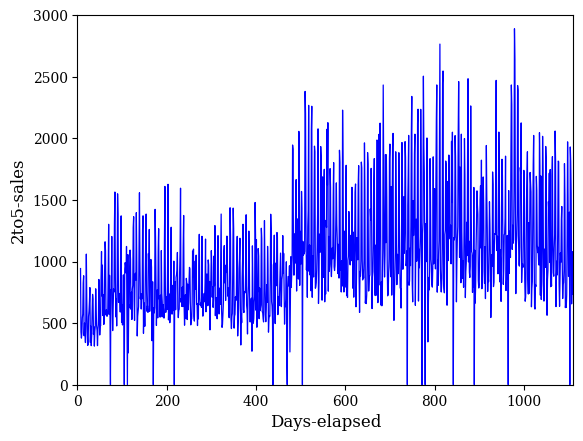

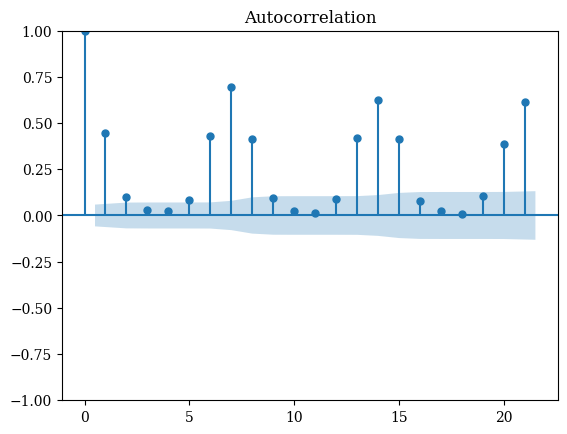

In [5]:
plt.plot(data['2to5'], "b", linewidth=.9)
plt.xlabel("Days-elapsed", fontsize=12)
plt.ylabel("2to5-sales", fontsize=12)
plt.axis([0,1111,0,3000])
plt.show();
plot_acf(data['2to5'], lags=21);

#### Differenced Dataset

To find remove trend me may difference daily. To remove weekly seasonality, we difference weekly. We must remove 14 days in order to properly difference and aquire statistical information, but we will only lose 7 more days than usual.

In [7]:
diff_data = pd.read_csv('RestaurantDataVets_All_2to5_Differenced.csv')
diff_data=diff_data.drop([x for x in range(14)])
diff_data["WeeklyDifference"] = diff_data.WeeklyDifference.astype(float)
diff_data["DailyDifference"] = diff_data.DailyDifference.astype(float)
diff_data["AvgWeeklyDiff"] = diff_data.AvgWeeklyDiff.astype(float)

diff_data

,Index,Group,DMY,MissingPrevDays,Year,Day,January,February,March,April,May,June,July,August,September,October,November,December,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Holiday,Carnival,LentFasting,Ramadan,ChristmasSeason,DailyAvg,WeeklyAvg,MinSales,MaxSales,DailyBusyness,WeeklyBusyness,2to5,AvgDailyDiff,AvgWeeklyDiff,MinDailyDiff,MaxDailyDiff,DailyDifference,WeeklyDifference,DiffDifference
14,15,0,9/25/2016,0,2016,25,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,559.68143,804.695,320.54,942.94,0.38422,0.77788,884.50,12.13538,276.490000,-515.39,321.11,60.29,-58.44,-118.73
15,16,0,9/26/2016,0,2016,26,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,581.336,451.52,320.54,942.94,0.41902,0.21044,397.49,15.575,-47.940000,-515.39,321.11,-487.01,-30.06,456.95
16,17,0,9/27/2016,0,2016,27,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,569.84563,349.45,320.54,942.94,0.40056,0.04645,499.57,-17.93067,57.820000,-515.39,321.11,102.08,121.21,19.13
17,18,0,9/28/2016,0,2016,28,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,565.71176,393.295,320.54,942.94,0.39391,0.11689,433.56,-10.43,42.620000,-515.39,321.11,-66.01,12.58,78.59
18,19,0,9/29/2016,0,2016,29,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,558.37,518.075,320.54,942.94,0.38212,0.31738,342.37,-13.69941,46.170000,-515.39,321.11,-91.19,-198.79,-107.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,1107,0,12/1/2019,0,2019,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1028.13505,1445.32063,225.3,2889.23,0.30137,0.45798,1558.69,1.0378,5.415190,-1827.44,1929.78,-254.53,36.64,291.17
1107,1108,0,12/2/2019,0,2019,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1028.61433,809.81044,225.3,2889.23,0.30155,0.21942,656.41,0.80673,-4.407278,-1827.44,1929.78,-902.28,-222.95,679.33
1108,1109,0,12/3/2019,0,2019,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1028.2784,769.94929,225.3,2889.23,0.30143,0.20445,875.43,-0.00907,12.210903,-1827.44,1929.78,219.02,-237.58,-456.6
1109,1110,0,12/4/2019,0,2019,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1028.14058,839.78481,225.3,2889.23,0.30137,0.23067,1079.06,0.18861,79.801529,-1827.44,1929.78,203.63,-321.44,-525.07


<b>Daily difference shape.

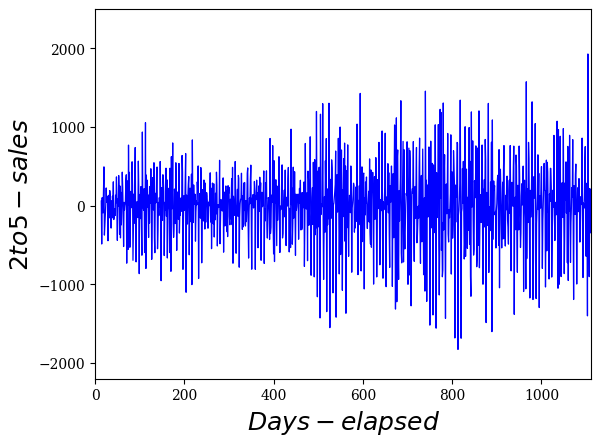

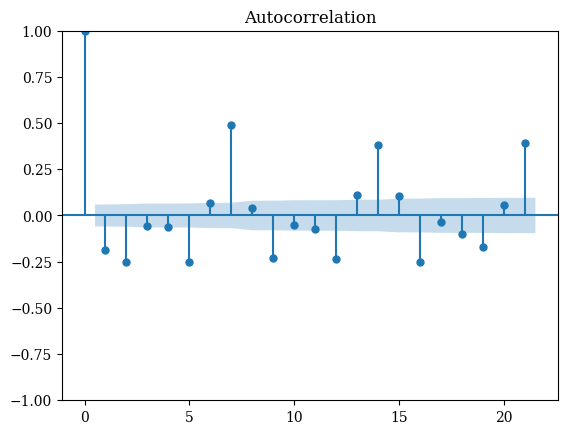

In [8]:
plt.plot(diff_data['DailyDifference'], "b", linewidth=.9)
plt.xlabel("$Days-elapsed$", fontsize=18)
plt.ylabel("$2to5-sales$", fontsize=18)
plt.axis([0,1111,-2200,2500])
plt.show();
plot_acf(diff_data['DailyDifference'], lags=21);

<b> Weekly difference shape.

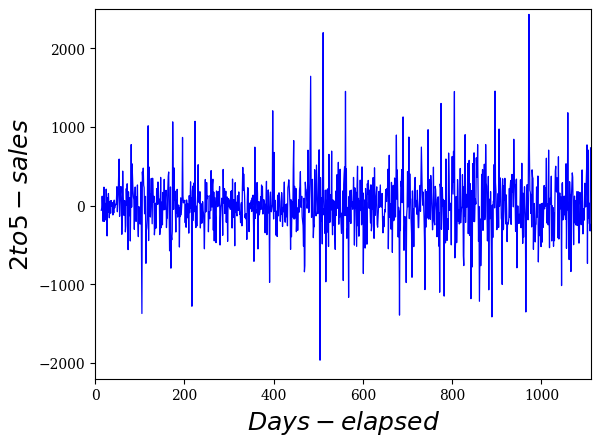

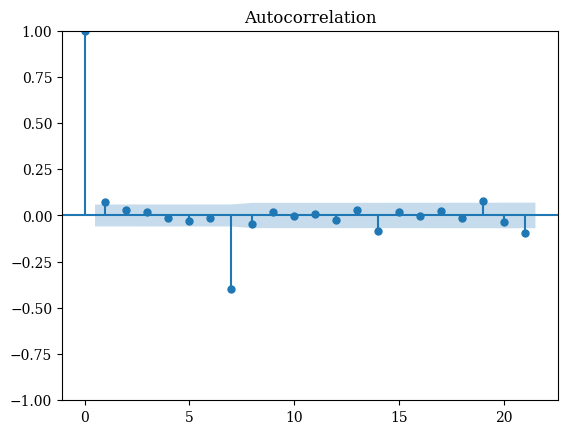

In [9]:
plt.plot(diff_data['WeeklyDifference'], "b", linewidth=.9)
plt.xlabel("$Days-elapsed$", fontsize=18)
plt.ylabel("$2to5-sales$", fontsize=18)
plt.axis([0,1111,-2200,2500])
plt.show()
plot_acf(diff_data['WeeklyDifference'], lags=21);

## One Week Forecast Window

In [10]:
def plot_series(time, series, label, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end],label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

### Scikit Learn Models

In [13]:
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import LinearSVR

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor 
from sklearn.kernel_ridge import KernelRidge


from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import f_regression, SelectKBest

from sklearn.metrics import  max_error, mean_absolute_error, mean_squared_error


In [11]:
#We apply one hot encoding for the Holiday feature to help linear models 
def onehotholiday(select):
    X_2 = select[['Holiday']]
    enc = preprocessing.OneHotEncoder(sparse=False)
    enc.fit(X_2)
    onehotlabels = enc.transform(X_2)
    # creating a list of column names 
    column_values = []
    for i in range(np.shape(onehotlabels)[1]):
            column_values.append('A'+str(i))

    onehotholiday = pd.DataFrame(data = onehotlabels,columns = column_values)
    dataset = select.drop(columns=['Holiday'])
    dataset = select.join(onehotholiday)
    df1 = dataset.pop('2to5')
    dataset['2to5']=df1 # add b series as a 'new' column
    dataset2=dataset
    dataset2 = dataset2.drop(columns=['Holiday'])
    return dataset2

    
def onehotholidaydiff(select, col):
    X_2 = select[['Holiday']]
    # TODO: create a OneHotEncoder object, and fit it to all of X
    # 1. INSTANTIATE
    enc = preprocessing.OneHotEncoder(sparse=False)
    
    # 2. FIT
    enc.fit(X_2)
    
    # 3. Transform
    onehotlabels = enc.transform(X_2)
    # creating a list of column names 
    column_values = []
    for i in range(np.shape(onehotlabels)[1]):
            column_values.append('A'+str(i))

    # creating the dataframe 
    onehotholiday = pd.DataFrame(data = onehotlabels,columns = column_values)

    dataset = select.drop(columns=['Holiday'])
    dataset = select.join(onehotholiday)
    df1 = dataset.pop(col)
    dataset[col]=df1 # add b series as a 'new' column
    dataset2=dataset
    dataset2 = dataset2.drop(columns=['Holiday'])
    return dataset2
    
def diff_add_lookback(dataset, look_back, df, col):
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)][col]
        a = a.values
        for j in range(len(a)):
            df[j][i]= a[j]
    return df

def add_lookback(dataset, look_back, df):
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]['2to5']
        a = a.values
        for j in range(len(a)):
            df[j][i]= a[j]
    return df

days = ["Friday","Saturday","Sunday","Monday","Tuesday","Wednesday","Thursday",]

#### Predicting Actual

In [20]:
dataframe = pd.read_csv('RestaurantDataVets_All_2to5.csv')
data = dataframe.drop(columns=['Index','Group','DMY','MissingPrevDays','DailyAvg','DailyBusyness'])
data.head(25)

,Year,Day,January,February,March,April,May,June,July,August,September,October,November,December,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Holiday,Carnival,LentFasting,Ramadan,ChristmasSeason,WeeklyAvg,MinSales,MaxSales,WeeklyBusyness,2to5
0,2016,11,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,?,?,?,?,666.45
1,2016,12,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,?,666.45,666.45,?,475.49
2,2016,13,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,?,475.49,666.45,?,320.54
3,2016,14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,?,320.54,666.45,?,365.61
4,2016,15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,?,320.54,666.45,?,494.99
5,2016,16,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,?,320.54,666.45,?,540.93
6,2016,17,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,?,320.54,666.45,?,862.04
7,2016,18,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,666.45,320.54,862.04,0.6387996,942.94
8,2016,19,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,475.49,320.54,942.94,0.2489557,427.55
9,2016,20,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,320.54,320.54,942.94,0,378.36


In [22]:
lookback=20
dataframe_removed_lookback = data.drop([x for x in range(lookback)])
dataframe_removed_lookback.head(25)

,Year,Day,January,February,March,April,May,June,July,August,September,October,November,December,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Holiday,Carnival,LentFasting,Ramadan,ChristmasSeason,WeeklyAvg,MinSales,MaxSales,WeeklyBusyness,2to5
20,2016,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,843.125,320.54,942.94,0.8396289,1060.11
21,2016,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,831.2966667,320.54,1060.11,0.690613,686.65
22,2016,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,433.51,320.54,1060.11,0.1527509,429.05
23,2016,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,399.49,320.54,1060.11,0.1067512,318.74
24,2016,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,406.7166667,318.74,1060.11,0.1186677,327.21
25,2016,6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,459.5066667,318.74,1060.11,0.1898737,553.29
26,2016,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,560.4033333,318.74,1060.11,0.3259686,596.13
27,2016,8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,915.4533333,318.74,1060.11,0.8048793,675.98
28,2016,9,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,795.135,318.74,1060.11,0.6425874,788.49
29,2016,10,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,19,0,0,0,0,432.395,318.74,1060.11,0.153304,343.07


In [23]:
for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0

dataframe_removed_lookback.head(25)

,Year,Day,January,February,March,April,May,June,July,August,September,October,November,December,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Holiday,Carnival,LentFasting,Ramadan,ChristmasSeason,WeeklyAvg,MinSales,MaxSales,WeeklyBusyness,2to5,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
20,2016,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,843.125,320.54,942.94,0.8396289,1060.11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
21,2016,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,831.2966667,320.54,1060.11,0.690613,686.65,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
22,2016,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,433.51,320.54,1060.11,0.1527509,429.05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
23,2016,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,399.49,320.54,1060.11,0.1067512,318.74,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
24,2016,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,406.7166667,318.74,1060.11,0.1186677,327.21,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25,2016,6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,459.5066667,318.74,1060.11,0.1898737,553.29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
26,2016,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,560.4033333,318.74,1060.11,0.3259686,596.13,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
27,2016,8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,915.4533333,318.74,1060.11,0.8048793,675.98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
28,2016,9,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,795.135,318.74,1060.11,0.6425874,788.49,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
29,2016,10,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,19,0,0,0,0,432.395,318.74,1060.11,0.153304,343.07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
np.random.seed(44)
# fix random seed for reproducibility
# load the dataset
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5.csv')
data = dataframe.drop(columns=['Index','Group','DMY','MissingPrevDays','DailyAvg','DailyBusyness'])

lookback=20
dataframe_removed_lookback = data.drop([x for x in range(lookback)])

for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0
    
df = dataframe_removed_lookback[['Year', 'Day', 'January','February',
                         'March','April','May','June','July',
                         'August', 'September', 'October', 'November',
                         'December','Sunday', 'Monday', 'Tuesday',
                         'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Holiday', 'Carnival', 
                         'LentFasting','Ramadan','ChristmasSeason',
                         'WeeklyAvg','MinSales','MaxSales',
                         'WeeklyBusyness',
                         0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                          14, 15, 16, 17, 18, 19,      
                         '2to5']]
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

lb_data = add_lookback(data, lookback, df)
lb_data = lb_data.reset_index(drop=True)

hotdata = onehotholiday(lb_data)
hotdata = hotdata.drop(columns=[14,15,16,17,18,19])

hot_numcols = len(hotdata.columns)
dataset = hotdata.values

lbset=lb_data.values
lb_numcols =  len(lb_data.columns)

print("train_df Shape:" ,lb_data.shape)
print("After encoding:", hotdata.shape)

X=dataset[:, 0:hot_numcols-1]
y=lbset[:, lb_numcols-7:lb_numcols]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)

C:\Users\Austin\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


train_df Shape: (1091, 51)
After encoding: (1091, 72)


In [16]:
hotdata[-224:]

,Year,Day,January,February,March,April,May,June,July,August,September,October,November,December,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Carnival,LentFasting,Ramadan,ChristmasSeason,WeeklyAvg,MinSales,MaxSales,WeeklyBusyness,0,1,2,3,4,5,6,7,8,9,10,11,12,13,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,2to5
867,2019,19,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,951.370556,225.3,2764.93,0.285896,1998.32,1705.52,707.15,915.86,987.54,1318.72,1047.87,1890.38,2483.64,997.58,1166.13,913.48,870.93,961.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,793.71
868,2019,20,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1417.619683,225.3,2764.93,0.469486,1705.52,707.15,915.86,987.54,1318.72,1047.87,1890.38,2483.64,997.58,1166.13,913.48,870.93,961.66,2262.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1601.26
869,2019,21,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1377.095781,225.3,2764.93,0.453529,707.15,915.86,987.54,1318.72,1047.87,1890.38,2483.64,997.58,1166.13,913.48,870.93,961.66,2262.90,1414.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
870,2019,22,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,763.258906,225.3,2764.93,0.211826,915.86,987.54,1318.72,1047.87,1890.38,2483.64,997.58,1166.13,913.48,870.93,961.66,2262.90,1414.03,1081.61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1090.89
871,2019,23,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,732.277040,225.3,2764.93,0.199626,987.54,1318.72,1047.87,1890.38,2483.64,997.58,1166.13,913.48,870.93,961.66,2262.90,1414.03,1081.61,1066.55,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,662.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2019,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1445.320629,225.3,2889.23,0.457978,984.38,699.66,813.69,828.38,934.72,1794.61,1538.60,625.75,659.24,626.92,733.80,1219.97,1971.24,1522.05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1558.69
1087,2019,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,809.810440,225.3,2889.23,0.219417,699.66,813.69,828.38,934.72,1794.61,1538.60,625.75,659.24,626.92,733.80,1219.97,1971.24,1522.05,879.36,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,656.41
1088,2019,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,769.949295,225.3,2889.23,0.204453,813.69,828.38,934.72,1794.61,1538.60,625.75,659.24,626.92,733.80,1219.97,1971.24,1522.05,879.36,1113.01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,875.43
1089,2019,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,839.784810,225.3,2889.23,0.230668,828.38,934.72,1794.61,1538.60,625.75,659.24,626.92,733.80,1219.97,1971.24,1522.05,879.36,1113.01,1400.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1079.06


<b> K-Neighbor Regression

224


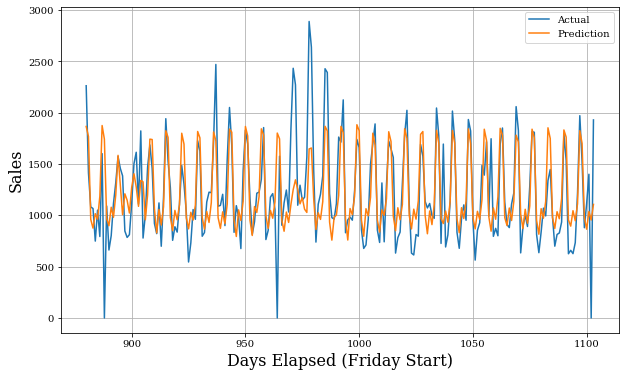

115611.52981725942
232.0444098772322
224


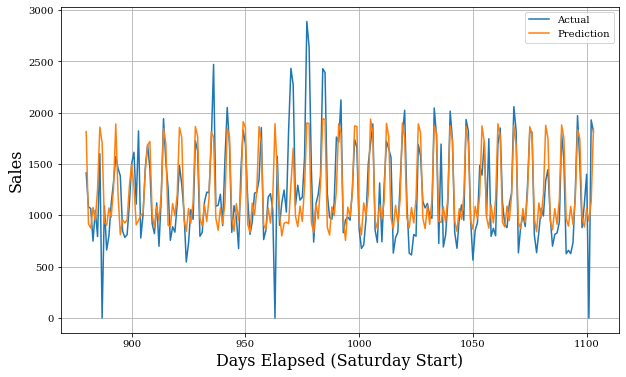

112750.4567221209
230.86899553571428
224


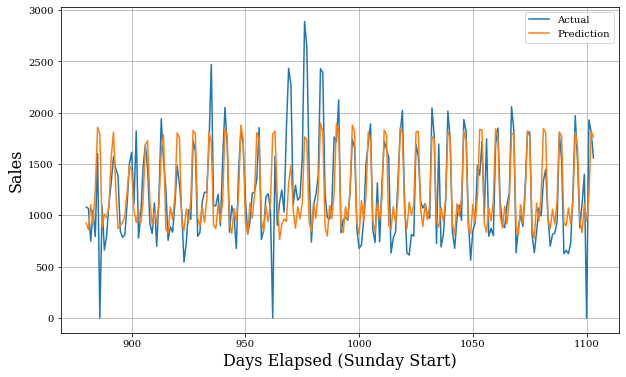

116756.52979164037
232.17217215401783
224


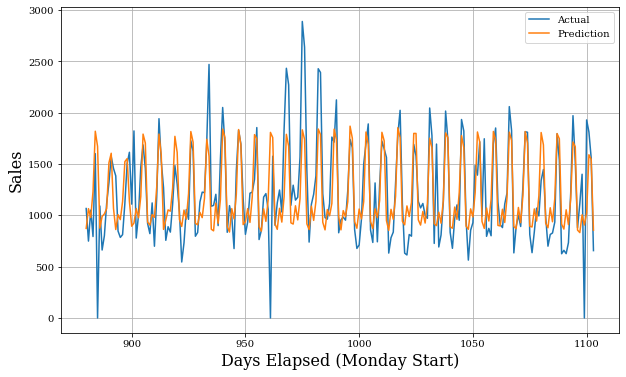

110743.41775881436
231.92825055803567
224


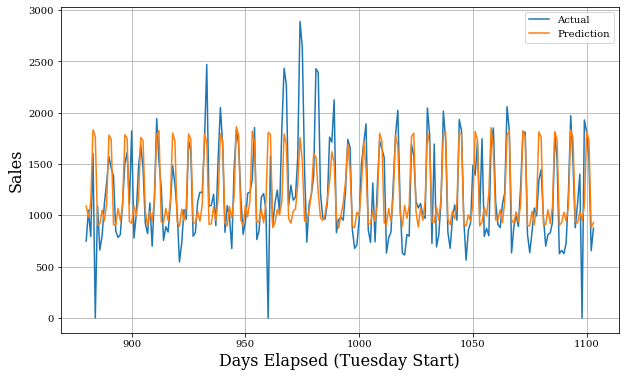

116919.48815380248
230.86510323660713
224


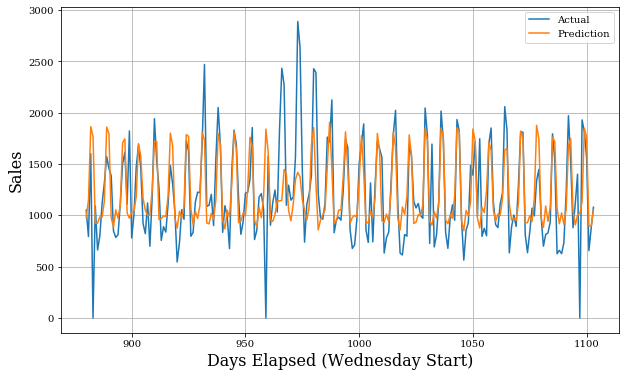

128718.0831214665
236.1103138950893
224


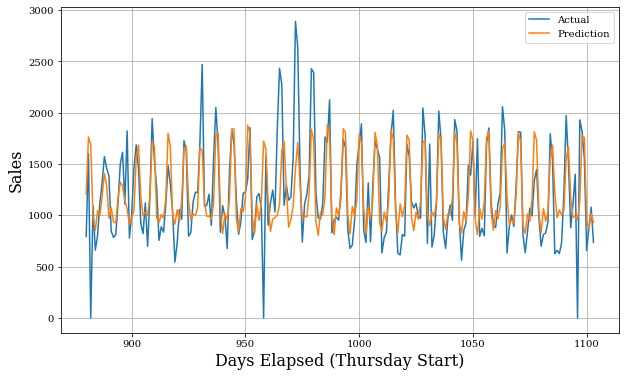

121903.66397081735
236.75648158482142


In [17]:
neigh = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=32))

feat_reduction = SelectKBest(f_regression, k=32) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    print(len(y_pred[i::7].flatten()))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label="Actual")
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label="Prediction")
    plt.title("",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="upper right")
    plt.savefig(fname='Charts/OneWeekPredict/Actual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())

<b> Extra Trees Regression

In [ ]:
et = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=1000, random_state=0,n_jobs=5))

feat_reduction = SelectKBest(f_regression, k=62) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

et.fit(X_train, y_train)
y_pred = et.predict(X_test)

for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    print(len(y_pred[i::7].flatten()))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label="Actual")
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label="Prediction")
    plt.title("Extra Trees Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="upper right")
    plt.savefig(fname='Charts/OneWeekPredict/ETWeek/ExtraTreesPredictonActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())

<b> Stacking Regression

In [ ]:
stack_nn = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 5, 5, 5, 5), random_state=42)
stack_neigh = KNeighborsRegressor(n_neighbors=7)
LR = LinearRegression()
rid = Ridge(alpha=1.0)
et = ExtraTreesRegressor(n_estimators=1000, random_state=0)

stack = MultiOutputRegressor(StackingCVRegressor(regressors=(LR, rid, et, stack_neigh, stack_nn),
                            meta_regressor=rid, 
                            random_state=41,
                            use_features_in_secondary=True))

feat_reduction = SelectKBest(f_regression, k=49) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    print(len(y_pred[i::7].flatten()))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label="Actual")
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label="Prediction")
    plt.title("Stacking Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="upper right")
    plt.savefig(fname='Charts/OneWeekPredict/StackWeek/StackingPredictonActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())

<b> Kernal Ridge Regression

In [ ]:
kridge = MultiOutputRegressor(KernelRidge())

feat_reduction = SelectKBest(f_regression, k=69) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

kridge.fit(X_train, y_train)
y_pred = kridge.predict(X_test)

for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    print(len(y_pred[i::7].flatten()))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label="Actual")
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label="Prediction")
    plt.title("Kernel Ridge Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="upper right")
    plt.savefig(fname='Charts/OneWeekPredict/KridgeWeek/KridgePredictonActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())

<b> SGD Regression

In [ ]:
sgd = MultiOutputRegressor(SGDRegressor())

feat_reduction = SelectKBest(f_regression, k=65) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    print(len(y_pred[i::7].flatten()))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label="Actual")
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label="Prediction")
    plt.title("SGD Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="upper right")
    plt.savefig(fname='Charts/OneWeekPredict/SGDWeek/SGDPredictonActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())

<b> Voting Regression

In [ ]:
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
reg4 = DecisionTreeRegressor(random_state=0,criterion="mae")
reg5 = SGDRegressor(max_iter=1000, tol=1e-3)

VR = MultiOutputRegressor(
    VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('dt',reg4), ('sgd',reg5)]))

feat_reduction = SelectKBest(f_regression, k=69) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

VR.fit(X_train, y_train)
y_pred = VR.predict(X_test)

for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    print(len(y_pred[i::7].flatten()))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label="Actual")
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label="Prediction")
    plt.title("Voting Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="upper right")
    plt.savefig(fname='Charts/OneWeekPredict/VRWeek/VotingPredictonActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())

<b> Bayesian Ridge Regression

In [ ]:
bridge = MultiOutputRegressor(BayesianRidge())

feat_reduction = SelectKBest(f_regression, k=59) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

bridge.fit(X_train, y_train)
y_pred = bridge.predict(X_test)

for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    print(len(y_pred[i::7].flatten()))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label="Actual")
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label="Prediction")
    plt.title("Bayesian Ridge Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="upper right")
    plt.savefig(fname='Charts/OneWeekPredict/BRidgeWeek/BridgePredictonActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())

<b> Lasso CV Regression

In [ ]:
lasso = MultiOutputRegressor(LassoCV())

feat_reduction = SelectKBest(f_regression, k=60) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    print(len(y_pred[i::7].flatten()))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label="Actual")
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label="Prediction")
    plt.title("Lasso Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="upper right")
    plt.savefig(fname='Charts/OneWeekPredict/LassoWeek/LassoPredictonActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())

# Predicting Difference

<b> Daily Difference

In [ ]:
np.random.seed(42)
# fix random seed for reproducibility
# load the dataset
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['Index','Group','DMY','MissingPrevDays','WeeklyDifference','DiffDifference',
                               'DailyAvg','DailyBusyness','AvgDailyDiff'])
remove=14
data = data.drop([x for x in range(remove)])
data = data.reset_index(drop=True)
lookback=20
dataframe_removed_lookback = data.drop([x for x in range(lookback)])

for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0
    
df = dataframe_removed_lookback[['Year', 'Day', 'January','February',
                         'March','April','May','June','July',
                         'August', 'September', 'October', 'November',
                         'December','Sunday', 'Monday', 'Tuesday',
                         'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Holiday', 'Carnival', 
                         'LentFasting','Ramadan','ChristmasSeason','WeeklyAvg','MinSales','MaxSales',
                          'WeeklyBusyness','AvgWeeklyDiff','MinDailyDiff',
                         'MaxDailyDiff',
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                 14, 15, 16, 17, 18, 19,  
                        'DailyDifference']]
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

#df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
df["DailyDifference"] = df.DailyDifference.astype(float)
#df["WeeklyDifference"] = df.WeeklyDifference.astype(float

lb_data = diff_add_lookback(data, lookback, df,'DailyDifference')
lb_data = lb_data.reset_index(drop=True)

hotdata = onehotholidaydiff(lb_data, 'DailyDifference')
hotdata = hotdata.drop(columns=[14,15,16,17,18,19])

hot_numcols = len(hotdata.columns)
dataset = hotdata.values

lbset=lb_data.values
lb_numcols =  len(lb_data.columns)

print("train_df Shape:" ,lb_data.shape)
print("After encoding:", hotdata.shape)

X=dataset[:, 0:hot_numcols-1]
y=lbset[:, lb_numcols-7:lb_numcols]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)

<b> Stacking Regression

In [ ]:
stack_neigh = KNeighborsRegressor(n_neighbors=7)
LR = LinearRegression()
rid = Ridge(alpha=1.0)
et = ExtraTreesRegressor(n_estimators=1000, random_state=0)

stack = MultiOutputRegressor(StackingCVRegressor(regressors=(LR, rid, et, stack_neigh),
                            meta_regressor=rid, 
                            random_state=41,
                            use_features_in_secondary=True))

feat_reduction = SelectKBest(f_regression, k=58) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
std = []
mean = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Stacking Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/StackWeek/StackPredictonDailyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std))  

In [ ]:
print(statistics.mean(mean))
print(statistics.stdev(std))

In [ ]:
y_test[0], y_pred[0]

<b> Lasso CV Regression

In [ ]:
lasso = MultiOutputRegressor(LassoCV())

feat_reduction = SelectKBest(f_regression, k=57) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Lasso Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/LassoWeek/LassoPredictonDailyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

In [ ]:
len(y_test)

<b> Kernel Ridge Regression

In [ ]:
kridge = MultiOutputRegressor(KernelRidge())

feat_reduction = SelectKBest(f_regression, k=57) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

kridge.fit(X_train, y_train)
y_pred = kridge.predict(X_test)
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Kernel Ridge Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/KRidgeWeek/KridgePredictonDailyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> Ridge Regression

In [ ]:
ridge = MultiOutputRegressor(Ridge())

feat_reduction = SelectKBest(f_regression, k=57) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Ridge Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/RidgeWeek/RidgePredictonDailyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> SGD Regression

In [ ]:
sgd = MultiOutputRegressor(SGDRegressor(max_iter=1000, tol=1e-8))

feat_reduction = SelectKBest(f_regression, k=62) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("SGD Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/SGDWeek/SGDPredictonDailyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

In [ ]:
y_pred

<b> Linear Regression

In [ ]:
lr = MultiOutputRegressor(LinearRegression())

feat_reduction = SelectKBest(f_regression, k=38) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Linear Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/LinearWeek/LinearPredictonDailyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> Bayesian Ridge Regression

In [ ]:
bridge = MultiOutputRegressor(BayesianRidge())

feat_reduction = SelectKBest(f_regression, k=46) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

bridge.fit(X_train, y_train)
y_pred = bridge.predict(X_test)

for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Bayesian Ridge Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/BRidgeWeek/BridgePredictonDailyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> Voting Regression

In [ ]:
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
reg4 = DecisionTreeRegressor(random_state=0,criterion="mae")
reg5 = SGDRegressor(max_iter=1000, tol=1e-3)

vr = MultiOutputRegressor(
    VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('dt',reg4),('sgd',reg5)]))

feat_reduction = SelectKBest(f_regression, k=55) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

vr.fit(X_train, y_train)
y_pred = vr.predict(X_test)
std= []
mean = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Voting Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/VRWeek/VotingPredictonDailyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> Weekly Difference

In [ ]:
np.random.seed(42)
# fix random seed for reproducibility
# load the dataset
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['Index','Group','DMY','MissingPrevDays', 'DailyDifference','DiffDifference','2to5',
                               'DailyAvg','DailyBusyness','AvgDailyDiff'])
remove=14
data = data.drop([x for x in range(remove)])
data = data.reset_index(drop=True)
lookback=20
dataframe_removed_lookback = data.drop([x for x in range(lookback)])

for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0
    
df = dataframe_removed_lookback[['Year', 'Day', 'January','February',
                         'March','April','May','June','July',
                         'August', 'September', 'October', 'November',
                         'December','Sunday', 'Monday', 'Tuesday',
                         'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Holiday', 'Carnival', 
                         'LentFasting','Ramadan','ChristmasSeason','WeeklyAvg','MinSales','MaxSales',
                          'WeeklyBusyness','AvgWeeklyDiff','MinDailyDiff',
                         'MaxDailyDiff',
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                 14, 15, 16, 17, 18, 19,  
                        'WeeklyDifference']]
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

#df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
#df["DailyDifference"] = df.DailyDifference.astype(float)
df["WeeklyDifference"] = df.WeeklyDifference.astype(float)

lb_data = diff_add_lookback(data, lookback, df,'WeeklyDifference')
lb_data = lb_data.reset_index(drop=True)

hotdata = onehotholidaydiff(lb_data, 'WeeklyDifference')
hotdata = hotdata.drop(columns=[14,15,16,17,18,19])

hot_numcols = len(hotdata.columns)
dataset = hotdata.values

lbset=lb_data.values
lb_numcols =  len(lb_data.columns)

print("train_df Shape:" ,lb_data.shape)
print("After encoding:", hotdata.shape)

X=dataset[:, 0:hot_numcols-1]
y=lbset[:, lb_numcols-7:lb_numcols]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)

<b> Lasso CV Regression

In [ ]:
lasso = MultiOutputRegressor(LassoCV())

feat_reduction = SelectKBest(f_regression, k=55) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
std = []
mean = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Lasso Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/LassoWeek/LassoPredictonWeeklyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

In [ ]:
y_test[0]

<b> Elastic Net CV Regression

In [ ]:
ele = MultiOutputRegressor(ElasticNetCV())

feat_reduction = SelectKBest(f_regression, k=54) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

ele.fit(X_train, y_train)
y_pred = ele.predict(X_test)
std = []
mean = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Elastic Net Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/ElasticWeek/ElasticPredictonWeeklyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> Linear SVR Regression

In [ ]:
svr = MultiOutputRegressor(LinearSVR())

feat_reduction = SelectKBest(f_regression, k=63) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=44, shuffle=False)

svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Linear SVR Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/SVRWeek/LinSVRPredictonWeeklyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> Bayesian Ridge Regression

In [ ]:
bridge = MultiOutputRegressor(BayesianRidge())

feat_reduction = SelectKBest(f_regression, k=54) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

bridge.fit(X_train, y_train)
y_pred = bridge.predict(X_test)
std = []
mean = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Bayesian Ridge Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/BRidgeWeek/BridgePredictonWeeklyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> SGD Regression

In [ ]:
sgd = MultiOutputRegressor(SGDRegressor(max_iter=1000, tol=1e-3))

feat_reduction = SelectKBest(f_regression, k=40) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("SGD Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/SGDWeek/SGDPredictonWeeklyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> Ridge Regression

In [ ]:
ridge = MultiOutputRegressor(Ridge())

feat_reduction = SelectKBest(f_regression, k=40) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Ridge Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/RidgeWeek/RidgePredictonWeeklyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> Kernel Ridge Regression

In [ ]:
kridge = MultiOutputRegressor(KernelRidge())

feat_reduction = SelectKBest(f_regression, k=40) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

kridge.fit(X_train, y_train)
y_pred = kridge.predict(X_test)
std = []
mean = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Kernel Ridge Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/KRidgeWeek/KridgePredictonWeeklyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

<b> Stacking Regression

In [ ]:
stack_neigh = KNeighborsRegressor(n_neighbors=7)
LR = LinearRegression()
rid = Ridge(alpha=1.0)
et = ExtraTreesRegressor(n_estimators=1000, random_state=0)

stack = MultiOutputRegressor(StackingCVRegressor(regressors=(LR, rid, et, stack_neigh),
                            meta_regressor=rid, 
                            random_state=41,
                            use_features_in_secondary=True))

feat_reduction = SelectKBest(f_regression, k=37) 
X_new = feat_reduction.fit_transform(X,y[:,0])

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
std= []
mean = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("Stacking Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/StackWeek/StackingPredictonWeeklyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(statistics.mean(mean))
print(statistics.stdev(std)) 

### Keras Models

#### Predicting Actual

In [ ]:
np.random.seed(42)
# fix random seed for reproducibility
# load the dataset
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5.csv')
data = dataframe.drop(columns=['Index','DMY','MissingPrevDays','DailyAvg','DailyBusyness'])

lookback=20
dataframe_removed_lookback = data.drop([x for x in range(lookback)])

for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0
    
df = dataframe_removed_lookback[['Year', 'Day', 'January','February',
                         'March','April','May','June','July',
                         'August', 'September', 'October', 'November',
                         'December','Sunday', 'Monday', 'Tuesday',
                         'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Holiday', 'Carnival', 
                         'LentFasting','Ramadan','ChristmasSeason',
                         'WeeklyAvg','MinSales','MaxSales',
                         'WeeklyBusyness',
                         0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                          14, 15, 16, 17, 18, 19,      
                         '2to5']]
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

lb_data = add_lookback(data, lookback, df)
lb_data = lb_data.reset_index(drop=True)

hotdata = onehotholiday(lb_data)
hotdata = hotdata.drop(columns=[14,15,16,17,18,19])

hot_numcols = len(hotdata.columns)
dataset = hotdata.values

lbset=lb_data.values
lb_numcols =  len(lb_data.columns)

print("train_df Shape:" ,lb_data.shape)
print("After encoding:", hotdata.shape)

X=dataset[:, 0:hot_numcols-1]
y=lbset[:, lb_numcols-7:lb_numcols]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)


In [ ]:
df

<b> Dense Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=1) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

dense = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Dense(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(16),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7)
])


es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
dense.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = dense.fit(X_train, y_train, epochs=200, callbacks=[es_callback])


y_pred = dense.predict(X_test)

In [ ]:
std = []
mean = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten())
    plot_series(time[-time_len:], y_pred[i::7].flatten())
    #plt.savefig(fname='Charts/OneWeekPredict/DenseWeek/DensePredictionActual'+str(i)+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

In [ ]:
np.mean(mean)

In [ ]:
np.std(std)

<b> Simple RNN Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=3) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

rnn = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.SimpleRNN(4),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=15)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

rnn.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = rnn.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = rnn.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("RNN Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/RNNWeek/RNNPredictionActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b>Convolutional LSTM Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=24) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

lstm = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=12)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

lstm.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = lstm.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = lstm.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("LSTM Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/LSTMWeek/LSTMPredictionActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b> GRU Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=19) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

gru = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=6)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

gru.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = gru.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = gru.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("GRU Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/GRUWeek/GRUPredictionActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b> Convolutional GRU Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=20) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

conv_gru = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(14),
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

conv_gru.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = conv_gru.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = conv_gru.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("GRU+ Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/ConvgruWeek/GRUCONVPredictionActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

#### Predicting Difference

<b> Daily Difference

In [ ]:
np.random.seed(42)
# fix random seed for reproducibility
# load the dataset
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['Index','Group','DMY','MissingPrevDays','WeeklyDifference','DailyAvg',
                               'DailyBusyness','AvgDailyDiff','DiffDifference','2to5'])
remove=1
data = data.drop([x for x in range(remove)])
data = data.reset_index(drop=True)
lookback=20
dataframe_removed_lookback = data.drop([x for x in range(lookback)])

for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0
    
df = dataframe_removed_lookback[['Year', 'Day', 'January','February',
                         'March','April','May','June','July',
                         'August', 'September', 'October', 'November',
                         'December','Sunday', 'Monday', 'Tuesday',
                         'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Holiday', 'Carnival', 
                         'LentFasting','Ramadan','ChristmasSeason','WeeklyAvg','MinSales','MaxSales',
                          'WeeklyBusyness','AvgWeeklyDiff','MinDailyDiff',
                         'MaxDailyDiff',
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                 14, 15, 16, 17, 18, 19,  
                        'DailyDifference']]
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

#df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
df["DailyDifference"] = df.DailyDifference.astype(float)
#df["WeeklyDifference"] = df.WeeklyDifference.astype(float

lb_data = diff_add_lookback(data, lookback, df,'DailyDifference')
lb_data = lb_data.reset_index(drop=True)

hotdata = onehotholidaydiff(lb_data, 'DailyDifference')
hotdata = hotdata.drop(columns=[14,15,16,17,18,19])


hot_numcols = len(hotdata.columns)
dataset = hotdata.values

lbset=lb_data.values
lb_numcols =  len(lb_data.columns)

print("train_df Shape:" ,lb_data.shape)
print("After encoding:", hotdata.shape)

X=dataset[:, 0:hot_numcols-1]
y=lbset[:, lb_numcols-7:lb_numcols]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)

<b> Dense Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=1) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

dense = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Dense(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(16),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7)
])


es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
dense.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = dense.fit(X_train, y_train, epochs=200, callbacks=[es_callback])


y_pred = dense.predict(X_test)

In [ ]:
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten())
    plot_series(time[-time_len:], y_pred[i::7].flatten())
    plt.savefig(fname='Charts/OneWeekPredict/DenseWeek/DensePredictionDailyDiff'+str(i)+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())

<b> Simple RNN Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=22) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

rnn = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.SimpleRNN(4),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=15)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

rnn.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = rnn.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = rnn.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("RNN Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/RNNWeek/RNNPredictionDailyDifference'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b> Convolutional LSTM Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=21) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

lstm = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=12)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

lstm.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = lstm.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = lstm.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("LSTM Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/LSTMWeek/LSTMPredictionDailyDifference'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b> GRU Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=37) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

gru = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=15)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

gru.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = gru.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = gru.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("GRU Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/GRUWeek/GRUPredictionDailyDifference'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b> Convolutional GRU Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=38) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

conv_gru = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(14),
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=15)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

conv_gru.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = conv_gru.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = conv_gru.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("GRU+ Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/ConvGRUWeek/GRUPredictionDailyDifference'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b> Weekly Difference

In [ ]:
np.random.seed(42)
# fix random seed for reproducibility
# load the dataset
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['Index','Group','DMY','MissingPrevDays','DailyDifference',
                               'DailyAvg','DailyBusyness','AvgDailyDiff','DiffDifference','2to5'])
remove=7
data = data.drop([x for x in range(remove)])
data = data.reset_index(drop=True)
lookback=20
dataframe_removed_lookback = data.drop([x for x in range(lookback)])

for i in range(lookback):
    dataframe_removed_lookback[i] = 1.0
    
df = dataframe_removed_lookback[['Year', 'Day', 'January','February',
                         'March','April','May','June','July',
                         'August', 'September', 'October', 'November',
                         'December','Sunday', 'Monday', 'Tuesday',
                         'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Holiday', 'Carnival', 
                         'LentFasting','Ramadan','ChristmasSeason','WeeklyAvg','MinSales','MaxSales',
                          'WeeklyBusyness','AvgWeeklyDiff','MinDailyDiff',
                         'MaxDailyDiff',
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                 14, 15, 16, 17, 18, 19,  
                        'WeeklyDifference']]
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

#df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
#df["DailyDifference"] = df.DailyDifference.astype(float)
df["WeeklyDifference"] = df.WeeklyDifference.astype(float)

lb_data = diff_add_lookback(data, lookback, df,'WeeklyDifference')
lb_data = lb_data.reset_index(drop=True)

hotdata = onehotholidaydiff(lb_data, 'WeeklyDifference')
hotdata = hotdata.drop(columns=[14,15,16,17,18,19])

hot_numcols = len(hotdata.columns)
dataset = hotdata.values

lbset=lb_data.values
lb_numcols =  len(lb_data.columns)

print("train_df Shape:" ,lb_data.shape)
print("After encoding:", hotdata.shape)


X=dataset[:, 0:hot_numcols-1]
y=lbset[:, lb_numcols-7:lb_numcols]

scaler = preprocessing.RobustScaler()
X = scaler.fit_transform(X,y)

<b> Dense Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=1) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

dense = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Dense(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(16),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7)
])


es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=18)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
dense.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = dense.fit(X_train, y_train, epochs=200, callbacks=[es_callback])


y_pred = dense.predict(X_test)

In [ ]:
mean=[]
std=[]
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten())
    plot_series(time[-time_len:], y_pred[i::7].flatten())
    #plt.savefig(fname='Charts/OneWeekPredict/DenseWeek/DensePredictionWeeklyDiff'+str(i)+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b> Simple RNN Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=7) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

rnn = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(8, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.SimpleRNN(4),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=15)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

rnn.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = rnn.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = rnn.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("RNN Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/RNNWeek/RNNPredictionWeeklyDifference'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b> Convolutional LSTM Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=74) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

lstm = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.LSTM(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=13)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

lstm.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = lstm.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = lstm.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("LSTM Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/LSTMWeek/LSTMPredictionWeeklyDifference'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b> GRU Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=11) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

gru = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=6)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

gru.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = gru.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = gru.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("GRU Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/GRUWeek/GRUPredictionWeeklyDifference'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

<b> Convolutional GRU Layers

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

feat_reduction = SelectKBest(f_regression, k=54) 
X_new = feat_reduction.fit_transform(X,y[:,0])
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=224, random_state=42, shuffle=False)

conv_gru = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32, return_sequences=True),
    keras.layers.Dropout(0.4),
    
    tf.keras.layers.GRU(32),
    keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(14),
    tf.keras.layers.Dense(7),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

conv_gru.compile(loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"])

history = conv_gru.fit(X_train, y_train, epochs=200, callbacks=[es_callback])
y_pred = conv_gru.predict(X_test)

In [ ]:
mean = []
std = []
for i in range(7):
    time_len = len(y_pred[i::7].flatten())
    plt.figure(figsize=(10, 6))
    plot_series(time[-time_len:], y_test[i::7].flatten(),label='Actual')
    plot_series(time[-time_len:], y_pred[i::7].flatten(),label='Prediction')
    plt.title("GRU+ Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/ConvGRUWeek/GRUCONVPredictionWeeklyDifference'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(y_test[i::7].flatten(), y_pred[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    std.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
    mean.append(keras.metrics.mean_absolute_error(y_test[i::7].flatten(),y_pred[i::7].flatten()).numpy())
print(np.mean(mean))
print(np.std(std))

### Transformer Model

In [ ]:
import pytorch_lightning as pl
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MAE
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

The Pytorch-Forecast library comes with great tools for generating time series datasets to use in training. As such, we generate out training data with these tools. Care is taken to ensure testing is completed as closely to the same manner as previous tests.

### Predicting Actual

In [ ]:
train_time=871
time = np.arange(1104, dtype="float32")
time_series = time[train_time:]

In [ ]:
data = pd.read_csv('Data/RestaurantDataVets_All_2to5.csv')
data = data.drop(columns=['DMY','MissingPrevDays', 'DailyBusyness','DailyAvg'])

remove=7
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

hotdata = onehotholiday(df)

numcols = len(hotdata.columns)
dataset = hotdata
dataset

In [ ]:
train_data, test_data= train_test_split(dataset, test_size=244, random_state=42, shuffle=False)

val_data = train_data[-80:]
train_data=train_data[:-80]

train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index

# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-84],
     time_idx="Index",
     target="2to5",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=7,
     max_prediction_length=7,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["Index","Year", "Day","January","February","March","April","May","June","July","August",
                               "September","October","November","December", "Sunday","Monday","Tuesday","Wednesday",
                               "Thursday","Friday","Saturday","Carnival","LentFasting","Ramadan",
                               "ChristmasSeason","WeeklyAvg","MinSales",
                               "MaxSales","WeeklyBusyness",
                               "A0","A1","A2", "A3","A4","A5","A6","A7","A8","A9",
                               "A10","A11","A12","A13","A14","A15","A16","A17",
                               "A18","A19","A20","A21","A22","A23","A24","A25","A26","A27"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["2to5"],
     
)

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

print("We batch our data into sizes of "+str(batch_size))
print("In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.")
print("In total, we train with " +str(batch_size*len(train_dataloader))+ " days.")
print("The 10% validation provides us with "+str(batch_size*len(val_dataloader))+" days.")
print("We test after fitting with "+str(batch_size*len(test_dataloader))+" days.")
print("In total, we have "+str(16*(len(train_dataloader) + len(val_dataloader) + len(test_dataloader)))+ " days.")

In [ ]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.6515398899400968)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.098833244460919,
    hidden_size=119,
    attention_head_size=2,
    dropout= 0.1518543467219442,
    hidden_continuous_size=9,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()

for i in range(7):
    time_len = len(actuals[i::7].flatten())
    print(time_len)
    plt.figure(figsize=(10, 6))
    plot_series(time_series[-time_len:], actuals[i::7].flatten(),label='Actual')
    plot_series(time_series[-time_len:], predictions[i::7].flatten(),label='Prediction')
    plt.title("TFT Actual One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/TransformerWeek/Actual/PredictionActual'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(actuals[i::7].flatten(), predictions[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(actuals[i::7].flatten(),predictions[i::7].flatten()).numpy())

In [ ]:
actuals[0]

### Predicting Actual - Less Features

In [ ]:
data = pd.read_csv('Data/RestaurantDataVets_All_2to5.csv')
data = data.drop(columns=['DMY','MissingPrevDays','DailyBusyness','DailyAvg'])

remove=7
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

hotdata = onehotholiday(df)

numcols = len(hotdata.columns)
dataset = hotdata
dataset

numcols = len(hotdata.columns)
X=hotdata.iloc[:, 0:numcols-1]
y=hotdata.iloc[:, numcols-1]

X_new = SelectKBest(f_regression, k='all').fit(X,y)

dfscores = pd.DataFrame(X_new.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(60,'Score'))  #print 10 best features
featureScores.to_csv('actualfeatscoresremovedlb.csv')

In [ ]:
train_data, test_data= train_test_split(dataset, test_size=244, random_state=42, shuffle=False)

val_data = train_data[-80:]
train_data=train_data[:-80]


train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index

# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-84],
     time_idx="Index",
     target="2to5",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=7,
     max_prediction_length=7,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["Index","WeeklyAvg","WeeklyBusyness","MaxSales",
                              "Year","MinSales", "Monday", "Tuesday",
                              "Wednesday","Thursday","Saturday","Sunday","A4","A1","A6","A23","A11","A26"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["2to5"],
     
)

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


print("We batch our data into sizes of "+str(batch_size))
print("In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.")
print("In total, we train with " +str(batch_size*len(train_dataloader))+ " days.")
print("The 10% validation provides us with "+str(batch_size*len(val_dataloader))+" days.")
print("We test after fitting with "+str(batch_size*len(test_dataloader))+" days.")
print("In total, we have "+str(16*(len(train_dataloader) + len(val_dataloader) + len(test_dataloader)))+ " days.")

In [ ]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.911641958284224)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.09841355116570298,
    hidden_size=122,
    attention_head_size=2,
    dropout=  0.2485422037534699,
    hidden_continuous_size=121,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()

for i in range(7):
    time_len = len(actuals[i::7].flatten())
    print(time_len)
    plt.figure(figsize=(10, 6))
    plot_series(time_series[-time_len:], actuals[i::7].flatten(),label='Actual')
    plot_series(time_series[-time_len:], predictions[i::7].flatten(),label='Prediction')
    plt.title("TFT Actual One-Week Forecast - Less Features",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/TransformerWeek/Actual/PredictionActualLessFeats'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(actuals[i::7].flatten(), predictions[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(actuals[i::7].flatten(),predictions[i::7].flatten()).numpy())

### Predicting Difference

 ### Daily Difference

In [ ]:
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['DMY','MissingPrevDays','WeeklyDifference','DiffDifference','2to5'
                                ,'DailyBusyness','DailyAvg','AvgDailyDiff'])

remove=14
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

#df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
df["DailyDifference"] = df.DailyDifference.astype(float)
#df["WeeklyDifference"] = df.WeeklyDifference.astype(float)

hotdata = onehotholidaydiff(df,'DailyDifference')

numcols = len(hotdata.columns)
dataset = hotdata
dataset

In [ ]:
train_data, test_data= train_test_split(dataset, test_size=244, random_state=42, shuffle=False)

val_data = train_data[-80:]
train_data=train_data[:-80]


train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index


# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-80],
     time_idx="Index",
     target="DailyDifference",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=7,
     max_prediction_length=7,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["Index","Year", "Day","January","February","March","April","May","June","July","August",
                               "September","October","November","December", "Sunday","Monday","Tuesday","Wednesday",
                               "Thursday","Friday","Saturday","Carnival","LentFasting","Ramadan",
                               "ChristmasSeason","WeeklyAvg","MinSales","MaxDailyDiff","MinDailyDiff",
                               "MaxSales","WeeklyBusyness", "AvgWeeklyDiff",
                               "A0","A1","A2", "A3","A4","A5","A6","A7","A8","A9",
                               "A10","A11","A12","A13","A14","A15","A16","A17",
                               "A18","A19","A20","A21","A22","A23","A24","A25","A26","A27"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["DailyDifference"],
     
 )

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

print("We batch our data into sizes of "+str(batch_size))
print("In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.")
print("In total, we train with " +str(batch_size*len(train_dataloader))+ " days.")
print("The 10% validation provides us with "+str(batch_size*len(val_dataloader))+" days.")
print("We test after fitting with "+str(batch_size*len(test_dataloader))+" days.")
print("In total, we have "+str(16*(len(train_dataloader) + len(val_dataloader) + len(test_dataloader)))+ " days.")

In [ ]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.060498028833929095)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.09965066342480189,
    hidden_size=128,
    attention_head_size=3,
    dropout= 0.270337693847159,
    hidden_continuous_size=53,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()

for i in range(7):
    time_len = len(actuals[i::7].flatten())
    print(time_len)
    plt.figure(figsize=(10, 6))
    plot_series(time_series[-time_len:], actuals[i::7].flatten(),label='Actual')
    plot_series(time_series[-time_len:], predictions[i::7].flatten(),label='Prediction')
    plt.title("TFT Daily Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/TransformerWeek/DailyDiff/PredictionDailyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(actuals[i::7].flatten(), predictions[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(actuals[i::7].flatten(),predictions[i::7].flatten()).numpy())

### Daily Difference - Less Features

In [ ]:
data = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = data.drop(columns=['DMY','MissingPrevDays','2to5','WeeklyDifference','DiffDifference', 'DailyAvg', 'AvgDailyDiff'])

remove=14
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)


#df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
df["DailyDifference"] = df.DailyDifference.astype(float)
hotdata = onehotholidaydiff(df,'DailyDifference')

numcols = len(hotdata.columns)
dataset = hotdata
dataset

numcols = len(hotdata.columns)
X=hotdata.iloc[:, 0:numcols-1]
y=hotdata.iloc[:, numcols-1]

X_new = SelectKBest(f_regression, k='all').fit(X,y)

dfscores = pd.DataFrame(X_new.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(60,'Score'))  #print 10 best features
featureScores.to_csv('daydifffeatscoresremovedlb.csv')

In [ ]:
train_data, test_data= train_test_split(dataset, test_size=244, random_state=42, shuffle=False)

val_data = train_data[-80:]
train_data=train_data[:-80]

train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index


# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-80],
     time_idx="Index",
     target="DailyDifference",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=7,
     max_prediction_length=7,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["Monday","Saturday","WeeklyBusyness","WeeklyAvg",
                              "AvgWeeklyDiff","Friday","A11","A23","A0","A6","A24","A7","A27"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["DailyDifference"],
     
 )

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.5745488117660288)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.09994016410626705,
    hidden_size=123,
    attention_head_size=4,
    dropout= 0.261710570138562,
    hidden_continuous_size=68,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()

for i in range(7):
    time_len = len(actuals[i::7].flatten())
    print(time_len)
    plt.figure(figsize=(10, 6))
    plot_series(time_series[-time_len:], actuals[i::7].flatten(),label='Actual')
    plot_series(time_series[-time_len:], predictions[i::7].flatten(),label='Prediction')
    plt.title("TFT Daily Differenced One-Week Forecast - Less Features",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Daily Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/TransformerWeek/DailyDiff/PredictionDailyDiffLessFeats'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(actuals[i::7].flatten(), predictions[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(actuals[i::7].flatten(),predictions[i::7].flatten()).numpy())

### Weekly Difference

In [ ]:
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['DMY','MissingPrevDays','DailyDifference','DiffDifference','2to5',
                              'DailyAvg','DailyBusyness','AvgDailyDiff'])

remove=14
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

#df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
#df["DailyDifference"] = df.DailyDifference.astype(float)
df["WeeklyDifference"] = df.WeeklyDifference.astype(float)

hotdata = onehotholidaydiff(df,'WeeklyDifference')

numcols = len(hotdata.columns)
dataset = hotdata
dataset

In [ ]:
train_data, test_data= train_test_split(dataset, test_size=244, random_state=42, shuffle=False)

val_data = train_data[-80:]
train_data=train_data[:-80]


train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index

# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-80],
     time_idx="Index",
     target="WeeklyDifference",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=7,
     max_prediction_length=7,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["Index","Year", "Day","January","February","March","April","May","June","July","August",
                               "September","October","November","December", "Sunday","Monday","Tuesday","Wednesday",
                               "Thursday","Friday","Saturday","Carnival","LentFasting","Ramadan",
                               "ChristmasSeason","WeeklyAvg","MinSales","MaxDailyDiff","MinDailyDiff",
                               "MaxSales","WeeklyBusyness", "AvgWeeklyDiff",
                               "A0","A1","A2", "A3","A4","A5","A6","A7","A8","A9",
                               "A10","A11","A12","A13","A14","A15","A16","A17",
                               "A18","A19","A20","A21","A22","A23","A24","A25","A26","A27"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["WeeklyDifference"],
     
 )

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

print("We batch our data into sizes of "+str(batch_size))
print("In our training dataset, we remove 10% for validation. Additional loss is needed to create a lookback window.")
print("In total, we train with " +str(batch_size*len(train_dataloader))+ " days.")
print("The 10% validation provides us with "+str(batch_size*len(val_dataloader))+" days.")
print("We test after fitting with "+str(batch_size*len(test_dataloader))+" days.")
print("In total, we have "+str(16*(len(train_dataloader) + len(val_dataloader) + len(test_dataloader)))+ " days.")

In [ ]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.03542660204271917)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.08725581446395367,
    hidden_size=127,
    attention_head_size=1,
    dropout=  0.23610003487870085,
    hidden_continuous_size=106,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()

for i in range(7):
    time_len = len(actuals[i::7].flatten())
    print(time_len)
    plt.figure(figsize=(10, 6))
    plot_series(time_series[-time_len:], actuals[i::7].flatten(),label='Actual')
    plot_series(time_series[-time_len:], predictions[i::7].flatten(),label='Prediction')
    plt.title("TFT Weekly Differenced One-Week Forecast",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/TransformerWeek/WeeklyDiff/PredictionWeeklyDiff'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(actuals[i::7].flatten(), predictions[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(actuals[i::7].flatten(),predictions[i::7].flatten()).numpy())

### Weekly Difference - Less Features

In [ ]:
dataframe = pd.read_csv('Data/RestaurantDataVets_All_2to5_Differenced.csv')
data = dataframe.drop(columns=['DMY','MissingPrevDays','DailyDifference','DiffDifference','2to5'])

remove=14
df = data.drop([x for x in range(remove)])
df = df.reset_index(drop=True)

#Objects need to be converted to float due to missing values at load time.
#df["DailyAvg"] = df.DailyAvg.astype(float)
df["WeeklyAvg"] = df.WeeklyAvg.astype(float)
df["MinSales"] = df.MinSales.astype(float)
df["MaxSales"] = df.MaxSales.astype(float)
#df["DailyBusyness"] = df.DailyBusyness.astype(float)
df["WeeklyBusyness"] = df.WeeklyBusyness.astype(float)

df["AvgDailyDiff"] = df.AvgDailyDiff.astype(float)
df["AvgWeeklyDiff"] = df.AvgWeeklyDiff.astype(float)
df["MaxDailyDiff"] = df.MaxDailyDiff.astype(float)
df["MinDailyDiff"] = df.MinDailyDiff.astype(float)
#df["DailyDifference"] = df.DailyDifference.astype(float)
df["WeeklyDifference"] = df.WeeklyDifference.astype(float)

hotdata = onehotholidaydiff(df,'WeeklyDifference')

numcols = len(hotdata.columns)
dataset = hotdata
dataset

numcols = len(hotdata.columns)
X=hotdata.iloc[:, 0:numcols-1]
y=hotdata.iloc[:, numcols-1]

X_new = SelectKBest(f_regression, k='all').fit(X,y)

dfscores = pd.DataFrame(X_new.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(60,'Score'))  #print 10 best features
featureScores.to_csv('weekdifffeatscoresremovedlb.csv')

In [ ]:
train_data, test_data= train_test_split(dataset, test_size=244, random_state=42, shuffle=False)

val_data = train_data[-80:]
train_data=train_data[:-80]


train_index = np.arange(1,len(train_data)+1, dtype="int")
val_index = np.arange(1,len(val_data)+1, dtype="int")
test_index = np.arange(1,len(test_data)+1, dtype="int")

train_data.Index = train_index
test_data.Index = test_index
val_data.Index = val_index

# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
     dataset[lambda x: x.Index < train_time-80],
     time_idx="Index",
     target="WeeklyDifference",
     group_ids=["Group"],
     min_encoder_length=14,  # allowing predictions without history
     max_encoder_length=14,
     min_prediction_length=7,
     max_prediction_length=7,
     static_categoricals=[],
     static_reals=[ ],
     time_varying_known_categoricals=[],
     
     time_varying_known_reals=["A11","A26","AvgWeeklyDiff","A23","A6","A18","A15","A27","A0"],
     time_varying_unknown_categoricals=[],
     time_varying_unknown_reals=["WeeklyDifference"],
     
 )

validating=TimeSeriesDataSet.from_dataset(training, val_data, stop_randomization=True)
testing=TimeSeriesDataSet.from_dataset(training, test_data, stop_randomization=True)

batch_size = 16

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validating.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
##Callbacks 
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=15, verbose=False, mode="min")


##Trainer wrapper for training parameters
trainer = pl.Trainer( callbacks=[early_stop_callback], 
                     max_epochs=400,
                     gradient_clip_val=0.17326072969911535)

#Model initialization
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.09355049810260364,
    hidden_size=123,
    attention_head_size=4,
    dropout=  0.2179922212966772,
    hidden_continuous_size=21,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(tft, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)

actuals = actuals.numpy()
predictions = predictions.numpy()

for i in range(7):
    time_len = len(actuals[i::7].flatten())
    print(time_len)
    plt.figure(figsize=(10, 6))
    plot_series(time_series[-time_len:], actuals[i::7].flatten(),label='Actual')
    plot_series(time_series[-time_len:], predictions[i::7].flatten(),label='Prediction')
    plt.title("TFT Weekly Differenced One-Week Forecast - Less Features",fontsize=16)
    plt.xlabel("Days Elapsed " + "("+days[i] +" Start)", fontsize=16)
    plt.ylabel("Weekly Differenced Sales", fontsize=16)
    plt.legend(loc="best")
    plt.savefig(fname='Charts/OneWeekPredict/TransformerWeek/WeeklyDiff/PredictionWeeklyDiffLessFeats'+days[i]+'.png',dpi=150)
    plt.show()
    print(keras.metrics.mean_squared_error(actuals[i::7].flatten(), predictions[i::7].flatten()).numpy())
    print(keras.metrics.mean_absolute_error(actuals[i::7].flatten(),predictions[i::7].flatten()).numpy())